In [19]:
#Importing libraries
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import tensorflow as tf

from tensorflow import keras
import tensorflow_addons as tfa

In [21]:
#Importing target feature
y = pd.read_csv('./Resources/critic_meta_score.csv')
y.drop(['index'], inplace = True, axis =1)
y

,critic_meta_score
0,100.0
1,100.0
2,100.0
3,100.0
4,100.0
...,...
8772,25.0
8773,20.0
8774,10.0
8775,0.0


In [22]:
#Impoting input features
X = pd.read_csv('./Resources/emotion_scores.csv')
X.drop(['index'], inplace = True, axis =1)
X

,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy
0,0.041667,0.000000,0.208333,0.041667,0.208333,0.041667,0.083333,0.041667,0.166667
1,0.090909,0.045455,0.227273,0.045455,0.181818,0.136364,0.045455,0.090909,0.045455
2,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.250000,0.000000,0.000000
3,0.037037,0.037037,0.222222,0.074074,0.222222,0.111111,0.037037,0.037037,0.111111
4,0.090909,0.090909,0.000000,0.090909,0.272727,0.181818,0.181818,0.090909,0.000000
...,...,...,...,...,...,...,...,...,...
8772,0.166667,0.166667,0.166667,0.000000,0.000000,0.333333,0.166667,0.000000,0.000000
8773,0.000000,0.000000,0.285714,0.000000,0.285714,0.142857,0.000000,0.000000,0.142857
8774,0.000000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.000000,0.125000
8775,0.090909,0.090909,0.090909,0.000000,0.090909,0.272727,0.272727,0.000000,0.000000


In [23]:
emotions = X.columns.to_list()
emotions

['fear',
 'anger',
 'trust',
 'surprise',
 'positive',
 'negative',
 'sadness',
 'disgust',
 'joy']

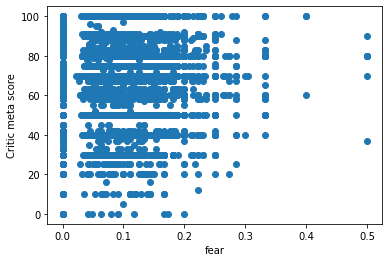

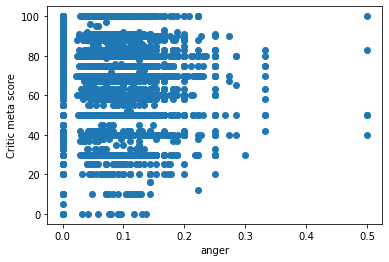

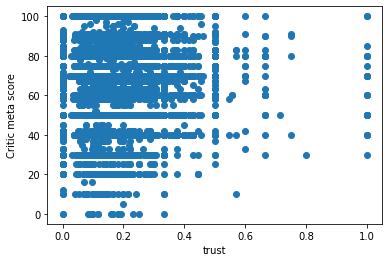

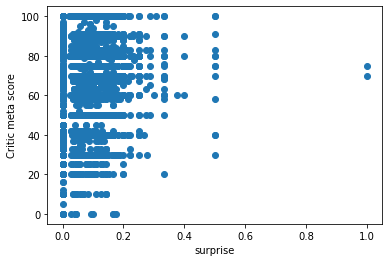

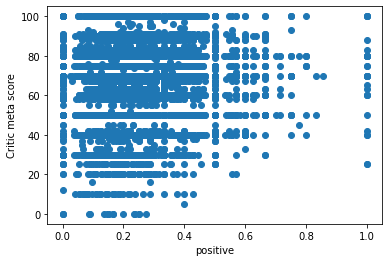

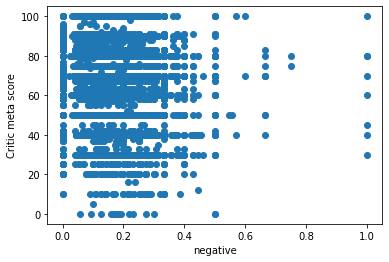

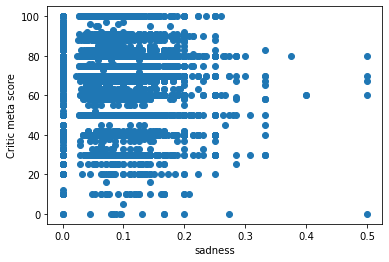

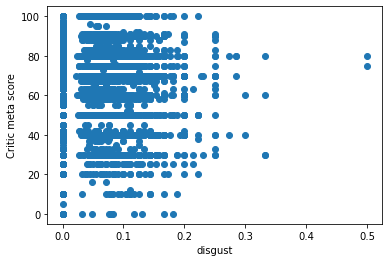

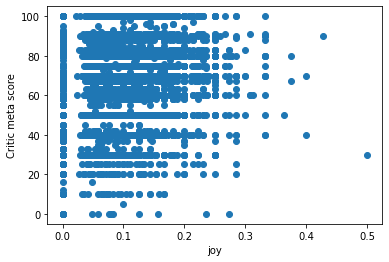

In [24]:
for emotion in emotions:
    plt.scatter(X[emotion], y.critic_meta_score)
    plt.xlabel(str(emotion))
    plt.ylabel('Critic meta score')
    plt.show()

In [25]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [26]:
# Create an instance of the model
model = LinearRegression()

In [27]:
model.fit(X_train, y_train)

LinearRegression()

In [28]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print(y_pred_train.shape)
print(y_pred_test.shape)

(6143, 1)
(2634, 1)


In [35]:
print(model.coef_)

[[ 24.92376492  17.97672394   3.86580161  23.26589821  10.36117401
  -11.14001064 -12.29032147 -11.4789197   21.12624982]]


In [36]:
print(model.intercept_)

[61.21137449]


In [30]:
print(model.score(X_train, y_train))

0.03100619130902904


In [31]:
print(model.score(X_test, y_test))

0.03404279227543461


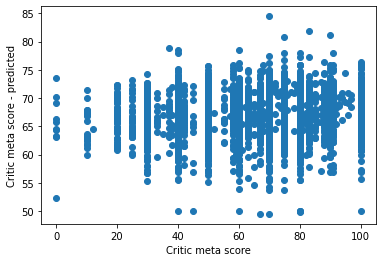

In [39]:
plt.scatter(y_train, y_pred_train)
plt.xlabel('Critic meta score')
plt.ylabel('Critic meta score - predicted')
plt.show()

In [37]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

C:\Users\bemal\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


 Random forest predictive accuracy: 0.126


In [53]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [60]:
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor = 'val_loss',
    mode = 'min',
    verbose=1,
    save_best_only=True,
    save_weights_only=True)


# Define the model - deep neural net
number_input_features = X_train.shape[1]
hidden_nodes_layer1 = 26
hidden_nodes_layer2 = 13
hidden_nodes_layer3 = 6

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="mean_squared_error", optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=["mean_squared_error"])


In [61]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=500,callbacks=[cp_callback])

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/500
192/192 [==============================] - 2s 5ms/step - loss: 1193.1886 - mean_squared_error: 1193.1886
Epoch 2/500
192/192 [==============================] - 1s 6ms/step - loss: 364.2090 - mean_squared_error: 364.2090
Epoch 3/500
192/192 [==============================] - 1s 8ms/step - loss: 360.7463 - mean_squared_error: 360.7463
Epoch 4/500
192/192 [==============================] - 1s 7ms/step - loss: 362.9353 - mean_squared_error: 362.9353
Epoch 5/500
192/192 [==============================] - 1s 8ms/step - loss: 362.0317 - mean_squared_error: 362.0317
Epoch 6/500
192/192 [==============================] - 1s 6ms/step - loss: 359.1020 - mean_squared_error: 359.1020
Epoch 7/500
192/192 [==============================] - 1s 6ms/step - loss: 357.0120 - mean_squared_error: 357.0120
Epoch 8/500
192/192 [==============================] - 1s 6ms/step - loss: 358.4989 - mean_squared_error: 358.4989
Epoch 9/500
192/192 [==============================] - 1s 7ms/step - loss: 356

Epoch 29/500
192/192 [==============================] - 1s 6ms/step - loss: 354.6051 - mean_squared_error: 354.6051
Epoch 30/500
192/192 [==============================] - 1s 6ms/step - loss: 356.9376 - mean_squared_error: 356.9376
Epoch 31/500
192/192 [==============================] - 2s 10ms/step - loss: 356.7779 - mean_squared_error: 356.7779
Epoch 32/500
192/192 [==============================] - 2s 8ms/step - loss: 354.7489 - mean_squared_error: 354.7489
Epoch 33/500
192/192 [==============================] - 1s 5ms/step - loss: 356.7772 - mean_squared_error: 356.7772
Epoch 34/500
192/192 [==============================] - 1s 6ms/step - loss: 354.8626 - mean_squared_error: 354.8626
Epoch 35/500
192/192 [==============================] - 1s 5ms/step - loss: 357.1604 - mean_squared_error: 357.1604
Epoch 36/500
192/192 [==============================] - 1s 4ms/step - loss: 357.0759 - mean_squared_error: 357.0759
Epoch 37/500
192/192 [==============================] - 1s 4ms/step - l

Epoch 57/500
192/192 [==============================] - 1s 4ms/step - loss: 354.3658 - mean_squared_error: 354.3658
Epoch 58/500
192/192 [==============================] - 1s 4ms/step - loss: 353.7628 - mean_squared_error: 353.7628
Epoch 59/500
192/192 [==============================] - 1s 5ms/step - loss: 354.5033 - mean_squared_error: 354.5033
Epoch 60/500
192/192 [==============================] - 1s 3ms/step - loss: 354.7490 - mean_squared_error: 354.7490
Epoch 61/500
192/192 [==============================] - 1s 3ms/step - loss: 356.1990 - mean_squared_error: 356.1990
Epoch 62/500
192/192 [==============================] - 1s 3ms/step - loss: 353.6859 - mean_squared_error: 353.6859
Epoch 63/500
192/192 [==============================] - 1s 3ms/step - loss: 353.4714 - mean_squared_error: 353.4714
Epoch 64/500
192/192 [==============================] - 1s 3ms/step - loss: 356.9533 - mean_squared_error: 356.9533
Epoch 65/500
192/192 [==============================] - 1s 3ms/step - lo

Epoch 85/500
192/192 [==============================] - 1s 4ms/step - loss: 352.5941 - mean_squared_error: 352.5941
Epoch 86/500
192/192 [==============================] - 1s 3ms/step - loss: 352.9307 - mean_squared_error: 352.9307
Epoch 87/500
192/192 [==============================] - 1s 3ms/step - loss: 358.5679 - mean_squared_error: 358.5679
Epoch 88/500
192/192 [==============================] - 1s 3ms/step - loss: 354.3746 - mean_squared_error: 354.3746
Epoch 89/500
192/192 [==============================] - 1s 3ms/step - loss: 352.9716 - mean_squared_error: 352.9716
Epoch 90/500
192/192 [==============================] - 1s 3ms/step - loss: 355.3077 - mean_squared_error: 355.3077
Epoch 91/500
192/192 [==============================] - 1s 3ms/step - loss: 353.1160 - mean_squared_error: 353.1160
Epoch 92/500
192/192 [==============================] - 1s 3ms/step - loss: 356.3642 - mean_squared_error: 356.3642
Epoch 93/500
192/192 [==============================] - 1s 3ms/step - lo

Epoch 113/500
192/192 [==============================] - 1s 4ms/step - loss: 351.9429 - mean_squared_error: 351.9429
Epoch 114/500
192/192 [==============================] - 1s 4ms/step - loss: 352.7379 - mean_squared_error: 352.7379
Epoch 115/500
192/192 [==============================] - 1s 4ms/step - loss: 352.6247 - mean_squared_error: 352.6247
Epoch 116/500
192/192 [==============================] - 1s 4ms/step - loss: 352.9136 - mean_squared_error: 352.9136
Epoch 117/500
192/192 [==============================] - 1s 4ms/step - loss: 354.7477 - mean_squared_error: 354.7477
Epoch 118/500
192/192 [==============================] - 1s 4ms/step - loss: 353.0538 - mean_squared_error: 353.0538
Epoch 119/500
192/192 [==============================] - 1s 4ms/step - loss: 351.7774 - mean_squared_error: 351.7774
Epoch 120/500
192/192 [==============================] - 1s 4ms/step - loss: 351.6511 - mean_squared_error: 351.6511
Epoch 121/500
192/192 [==============================] - 1s 4ms/

Epoch 141/500
192/192 [==============================] - 1s 4ms/step - loss: 353.4597 - mean_squared_error: 353.4597
Epoch 142/500
192/192 [==============================] - 1s 4ms/step - loss: 351.7822 - mean_squared_error: 351.7822
Epoch 143/500
192/192 [==============================] - 1s 3ms/step - loss: 351.5136 - mean_squared_error: 351.5136
Epoch 144/500
192/192 [==============================] - 1s 4ms/step - loss: 350.7867 - mean_squared_error: 350.7867
Epoch 145/500
192/192 [==============================] - 1s 3ms/step - loss: 352.5672 - mean_squared_error: 352.5672
Epoch 146/500
192/192 [==============================] - 1s 4ms/step - loss: 351.4766 - mean_squared_error: 351.4766
Epoch 147/500
192/192 [==============================] - 1s 3ms/step - loss: 351.3666 - mean_squared_error: 351.3666
Epoch 148/500
192/192 [==============================] - 1s 4ms/step - loss: 350.9893 - mean_squared_error: 350.9893
Epoch 149/500
192/192 [==============================] - 1s 3ms/

Epoch 169/500
192/192 [==============================] - 1s 4ms/step - loss: 349.6133 - mean_squared_error: 349.6133
Epoch 170/500
192/192 [==============================] - 1s 4ms/step - loss: 352.0759 - mean_squared_error: 352.0759
Epoch 171/500
192/192 [==============================] - 1s 4ms/step - loss: 349.9713 - mean_squared_error: 349.9713
Epoch 172/500
192/192 [==============================] - 1s 4ms/step - loss: 350.8769 - mean_squared_error: 350.8769
Epoch 173/500
192/192 [==============================] - 1s 4ms/step - loss: 349.3653 - mean_squared_error: 349.3653
Epoch 174/500
192/192 [==============================] - 1s 4ms/step - loss: 349.7953 - mean_squared_error: 349.7953
Epoch 175/500
192/192 [==============================] - 1s 4ms/step - loss: 350.0003 - mean_squared_error: 350.0003
Epoch 176/500
192/192 [==============================] - 1s 4ms/step - loss: 351.3252 - mean_squared_error: 351.3252
Epoch 177/500
192/192 [==============================] - 1s 4ms/

Epoch 197/500
192/192 [==============================] - 1s 4ms/step - loss: 348.9246 - mean_squared_error: 348.9246
Epoch 198/500
192/192 [==============================] - 1s 4ms/step - loss: 348.9854 - mean_squared_error: 348.9854
Epoch 199/500
192/192 [==============================] - 1s 4ms/step - loss: 348.7610 - mean_squared_error: 348.7610
Epoch 200/500
192/192 [==============================] - 1s 4ms/step - loss: 348.9985 - mean_squared_error: 348.9985
Epoch 201/500
192/192 [==============================] - 1s 4ms/step - loss: 350.2864 - mean_squared_error: 350.2864
Epoch 202/500
192/192 [==============================] - 1s 3ms/step - loss: 348.9632 - mean_squared_error: 348.9632
Epoch 203/500
192/192 [==============================] - 1s 4ms/step - loss: 348.6968 - mean_squared_error: 348.6968
Epoch 204/500
192/192 [==============================] - 1s 4ms/step - loss: 348.8907 - mean_squared_error: 348.8907
Epoch 205/500
192/192 [==============================] - 1s 4ms/

Epoch 225/500
192/192 [==============================] - 1s 3ms/step - loss: 346.3854 - mean_squared_error: 346.3854
Epoch 226/500
192/192 [==============================] - 1s 3ms/step - loss: 345.9112 - mean_squared_error: 345.9112
Epoch 227/500
192/192 [==============================] - 1s 3ms/step - loss: 349.2119 - mean_squared_error: 349.2119
Epoch 228/500
192/192 [==============================] - 1s 3ms/step - loss: 345.4534 - mean_squared_error: 345.4534
Epoch 229/500
192/192 [==============================] - 1s 3ms/step - loss: 347.6813 - mean_squared_error: 347.6813
Epoch 230/500
192/192 [==============================] - 1s 3ms/step - loss: 347.6952 - mean_squared_error: 347.6952
Epoch 231/500
192/192 [==============================] - 1s 3ms/step - loss: 346.3531 - mean_squared_error: 346.3531
Epoch 232/500
192/192 [==============================] - 1s 3ms/step - loss: 347.4844 - mean_squared_error: 347.4844
Epoch 233/500
192/192 [==============================] - 1s 3ms/

Epoch 253/500
192/192 [==============================] - 1s 4ms/step - loss: 348.2894 - mean_squared_error: 348.2894
Epoch 254/500
192/192 [==============================] - 1s 3ms/step - loss: 345.7688 - mean_squared_error: 345.7688
Epoch 255/500
192/192 [==============================] - 1s 4ms/step - loss: 344.6954 - mean_squared_error: 344.6954
Epoch 256/500
192/192 [==============================] - 1s 3ms/step - loss: 345.8402 - mean_squared_error: 345.8402
Epoch 257/500
192/192 [==============================] - 1s 3ms/step - loss: 343.8755 - mean_squared_error: 343.8755
Epoch 258/500
192/192 [==============================] - 1s 3ms/step - loss: 345.7356 - mean_squared_error: 345.7356
Epoch 259/500
192/192 [==============================] - 1s 4ms/step - loss: 345.1633 - mean_squared_error: 345.1633
Epoch 260/500
192/192 [==============================] - 1s 4ms/step - loss: 345.4764 - mean_squared_error: 345.4764
Epoch 261/500
192/192 [==============================] - 1s 4ms/

Epoch 281/500
192/192 [==============================] - 1s 4ms/step - loss: 346.7784 - mean_squared_error: 346.7784
Epoch 282/500
192/192 [==============================] - 1s 5ms/step - loss: 344.8511 - mean_squared_error: 344.8511
Epoch 283/500
192/192 [==============================] - 1s 5ms/step - loss: 346.2465 - mean_squared_error: 346.2465
Epoch 284/500
192/192 [==============================] - 1s 5ms/step - loss: 343.6961 - mean_squared_error: 343.6961
Epoch 285/500
192/192 [==============================] - 1s 4ms/step - loss: 344.7232 - mean_squared_error: 344.7232
Epoch 286/500
192/192 [==============================] - 1s 4ms/step - loss: 343.9457 - mean_squared_error: 343.9457
Epoch 287/500
192/192 [==============================] - 1s 4ms/step - loss: 344.2179 - mean_squared_error: 344.2179
Epoch 288/500
192/192 [==============================] - 1s 4ms/step - loss: 344.5224 - mean_squared_error: 344.5224
Epoch 289/500
192/192 [==============================] - 1s 4ms/

Epoch 309/500
192/192 [==============================] - 1s 4ms/step - loss: 343.1102 - mean_squared_error: 343.1102
Epoch 310/500
192/192 [==============================] - 1s 4ms/step - loss: 343.4708 - mean_squared_error: 343.4708
Epoch 311/500
192/192 [==============================] - 1s 3ms/step - loss: 344.0679 - mean_squared_error: 344.0679
Epoch 312/500
192/192 [==============================] - 1s 4ms/step - loss: 344.5654 - mean_squared_error: 344.5654
Epoch 313/500
192/192 [==============================] - 1s 3ms/step - loss: 345.2589 - mean_squared_error: 345.2589
Epoch 314/500
192/192 [==============================] - 1s 4ms/step - loss: 343.9418 - mean_squared_error: 343.9418
Epoch 315/500
192/192 [==============================] - 1s 4ms/step - loss: 343.7605 - mean_squared_error: 343.7605
Epoch 316/500
192/192 [==============================] - 1s 5ms/step - loss: 343.6649 - mean_squared_error: 343.6649
Epoch 317/500
192/192 [==============================] - 1s 4ms/

Epoch 337/500
192/192 [==============================] - 1s 4ms/step - loss: 342.9094 - mean_squared_error: 342.9094
Epoch 338/500
192/192 [==============================] - 1s 4ms/step - loss: 342.1481 - mean_squared_error: 342.1481
Epoch 339/500
192/192 [==============================] - 1s 4ms/step - loss: 342.9689 - mean_squared_error: 342.9689
Epoch 340/500
192/192 [==============================] - 1s 4ms/step - loss: 343.9467 - mean_squared_error: 343.9467
Epoch 341/500
192/192 [==============================] - 1s 4ms/step - loss: 342.8459 - mean_squared_error: 342.8459
Epoch 342/500
192/192 [==============================] - 1s 4ms/step - loss: 343.6892 - mean_squared_error: 343.6892
Epoch 343/500
192/192 [==============================] - 1s 3ms/step - loss: 343.6550 - mean_squared_error: 343.6550
Epoch 344/500
192/192 [==============================] - 1s 4ms/step - loss: 344.3113 - mean_squared_error: 344.3113
Epoch 345/500
192/192 [==============================] - 1s 4ms/

Epoch 365/500
192/192 [==============================] - 1s 4ms/step - loss: 341.2693 - mean_squared_error: 341.2693
Epoch 366/500
192/192 [==============================] - 1s 4ms/step - loss: 342.2589 - mean_squared_error: 342.2589
Epoch 367/500
192/192 [==============================] - 1s 4ms/step - loss: 339.9511 - mean_squared_error: 339.9511
Epoch 368/500
192/192 [==============================] - 1s 4ms/step - loss: 341.3019 - mean_squared_error: 341.3019
Epoch 369/500
192/192 [==============================] - 1s 3ms/step - loss: 341.0976 - mean_squared_error: 341.0976
Epoch 370/500
192/192 [==============================] - 1s 4ms/step - loss: 340.8790 - mean_squared_error: 340.8790
Epoch 371/500
192/192 [==============================] - 1s 4ms/step - loss: 341.5548 - mean_squared_error: 341.5548
Epoch 372/500
192/192 [==============================] - 1s 4ms/step - loss: 341.1222 - mean_squared_error: 341.1222
Epoch 373/500
192/192 [==============================] - 1s 4ms/

Epoch 393/500
192/192 [==============================] - 1s 3ms/step - loss: 340.4009 - mean_squared_error: 340.4009
Epoch 394/500
192/192 [==============================] - 1s 3ms/step - loss: 341.6746 - mean_squared_error: 341.6746
Epoch 395/500
192/192 [==============================] - 1s 3ms/step - loss: 340.8705 - mean_squared_error: 340.8705
Epoch 396/500
192/192 [==============================] - 1s 3ms/step - loss: 341.2059 - mean_squared_error: 341.2059
Epoch 397/500
192/192 [==============================] - 1s 3ms/step - loss: 341.8814 - mean_squared_error: 341.8814
Epoch 398/500
192/192 [==============================] - 1s 3ms/step - loss: 341.3611 - mean_squared_error: 341.3611
Epoch 399/500
192/192 [==============================] - 1s 3ms/step - loss: 339.7357 - mean_squared_error: 339.7357
Epoch 400/500
192/192 [==============================] - 1s 3ms/step - loss: 341.3032 - mean_squared_error: 341.3032
Epoch 401/500
192/192 [==============================] - 1s 7ms/

Epoch 421/500
192/192 [==============================] - 1s 4ms/step - loss: 340.7080 - mean_squared_error: 340.7080
Epoch 422/500
192/192 [==============================] - 1s 4ms/step - loss: 340.4361 - mean_squared_error: 340.4361
Epoch 423/500
192/192 [==============================] - 1s 4ms/step - loss: 339.5172 - mean_squared_error: 339.5172
Epoch 424/500
192/192 [==============================] - 1s 4ms/step - loss: 339.6284 - mean_squared_error: 339.6284
Epoch 425/500
192/192 [==============================] - 1s 4ms/step - loss: 339.7586 - mean_squared_error: 339.7586
Epoch 426/500
192/192 [==============================] - 1s 4ms/step - loss: 340.5473 - mean_squared_error: 340.5473
Epoch 427/500
192/192 [==============================] - 1s 4ms/step - loss: 341.1607 - mean_squared_error: 341.1607
Epoch 428/500
192/192 [==============================] - 1s 4ms/step - loss: 341.8881 - mean_squared_error: 341.8881
Epoch 429/500
192/192 [==============================] - 1s 4ms/

Epoch 449/500
192/192 [==============================] - 1s 4ms/step - loss: 339.8860 - mean_squared_error: 339.8860
Epoch 450/500
192/192 [==============================] - 1s 4ms/step - loss: 339.7593 - mean_squared_error: 339.7593
Epoch 451/500
192/192 [==============================] - 1s 4ms/step - loss: 340.4252 - mean_squared_error: 340.4252
Epoch 452/500
192/192 [==============================] - 1s 4ms/step - loss: 341.2439 - mean_squared_error: 341.2439
Epoch 453/500
192/192 [==============================] - 1s 4ms/step - loss: 339.8008 - mean_squared_error: 339.8008
Epoch 454/500
192/192 [==============================] - 1s 4ms/step - loss: 339.6733 - mean_squared_error: 339.6733
Epoch 455/500
192/192 [==============================] - 1s 4ms/step - loss: 340.1580 - mean_squared_error: 340.1580
Epoch 456/500
192/192 [==============================] - 1s 4ms/step - loss: 339.8806 - mean_squared_error: 339.8806
Epoch 457/500
192/192 [==============================] - 1s 3ms/

Epoch 477/500
192/192 [==============================] - 1s 4ms/step - loss: 340.2128 - mean_squared_error: 340.2128
Epoch 478/500
192/192 [==============================] - 1s 4ms/step - loss: 340.1817 - mean_squared_error: 340.1817
Epoch 479/500
192/192 [==============================] - 1s 4ms/step - loss: 339.7052 - mean_squared_error: 339.7052
Epoch 480/500
192/192 [==============================] - 1s 4ms/step - loss: 340.4144 - mean_squared_error: 340.4144
Epoch 481/500
192/192 [==============================] - 1s 4ms/step - loss: 340.9414 - mean_squared_error: 340.9414
Epoch 482/500
192/192 [==============================] - 1s 4ms/step - loss: 339.1619 - mean_squared_error: 339.1619
Epoch 483/500
192/192 [==============================] - 1s 4ms/step - loss: 340.3243 - mean_squared_error: 340.3243
Epoch 484/500
192/192 [==============================] - 1s 4ms/step - loss: 339.7859 - mean_squared_error: 339.7859
Epoch 485/500
192/192 [==============================] - 1s 5ms/

In [63]:
# Export our model to HDF5 file
nn.save("./Resources/TV_shows_NN.h5")

In [7]:
# Loading the model from the h5 file
nn = keras.models.load_model("./Resources/TV_shows_NN.h5")

In [33]:
# Defining true y values and predicted y values for test set
y_true = y_test
y_pred = model.predict(X_test)


In [34]:
# Calculating thr R2
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_true, y_pred)
result = metric.result()
result.numpy()

0.03404224

In [41]:
# Checking the model structure
nn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 26)                260       
                                                                 
 dense_28 (Dense)            (None, 13)                351       
                                                                 
 dense_29 (Dense)            (None, 6)                 84        
                                                                 
 dense_30 (Dense)            (None, 1)                 7         
                                                                 
Total params: 702
Trainable params: 702
Non-trainable params: 0
_________________________________________________________________
